# Notebook for PyGT Tests on GPU with Lightning

### Data Preparation

#### Create Graphs

In [ ]:
import torch
import pandas as pd
import numpy as np

# Read busses and edges
busses = pd.read_excel('Busses_Timeseries_Table_2022.xlsx')
edges = pd.read_excel('Edges_Timeseries_Table_2022.xlsx')

#Functions to create graph from (busses, edges)-sample
def sourceNodes(timestamp):
    source = edges.loc[edges['datetime_beginning_utc'] == timestamp, 'From Number']
    target = edges.loc[edges['datetime_beginning_utc'] == timestamp, 'To Number']
    sourceNp = pd.concat([source, target])
    targetNp = pd.concat([target, source])
    return (sourceNp, targetNp)
    
def nodeAttributes(timestamp):
    attributes = busses.loc[busses['datetime_beginning_utc'] == timestamp, ['mw_norm', 'incremental_price', 'inter_start_cost', 'min_ecomin', 'max_ecomax']]
    return attributes.to_numpy()

# Approach to only use capacity, mostly used    
def edgeAttributes(timestamp):
    attributes = edges.loc[edges['datetime_beginning_utc'] == timestamp, ['X', 'Lim MVA A']]
    weights = attributes['Lim MVA A'] # The models can not handle multiple edge features -> choose or connect
    attributes2 = pd.concat([weights, weights], axis=0).to_numpy()
    return attributes2

# Approach to integrate reactance and capactiy  
def edgeAttributesConnected(timestamp):
    attributes = edges.loc[edges['datetime_beginning_utc'] == timestamp, ['X', 'Lim MVA A']]
    sumLimit = sum(attributes['Lim MVA A'])
    weights = attributes['X'] * attributes['Lim MVA A'] / sumLimit # Use aggregation with weighting of capacity
    attributes2 = pd.concat([weights, weights], axis=0).to_numpy()
    return attributes2

def solAttributes(timestamp):
    attributes = busses.loc[busses['datetime_beginning_utc'] == timestamp, ['solTheta', 'solGenerate']]
    return attributes.to_numpy()

# To only test for generation prediction
def solAttributesT1(timestamp):
    attributes = busses.loc[busses['datetime_beginning_utc'] == timestamp, ['solTheta']]
    return attributes.to_numpy()  

In [ ]:
# Temporal data snapshots are PyTorch Geometric data object for each snapshot
# Iterated by DynamicGraphTemporalSignal

import torch_geometric_temporal
from torch_geometric_temporal.signal.dynamic_graph_temporal_signal import DynamicGraphTemporalSignal
timestamps = busses['datetime_beginning_utc'].unique()
numGraph = len(timestamps)
edge_indices = list()
features = list()
targets = list()
edge_weights = list()

# Append graphs per time
timeInterval = 0
for timeInterval in range(numGraph):  
    timestamp = pd.Timestamp(timestamps[timeInterval])
    source, target = sourceNodes(timestamp)
    edge_index = np.array([source, target], dtype=np.float32)
    x = np.array(nodeAttributes(timestamp), dtype=np.float32)
    y  = np.array(solAttributes(timestamp), dtype=np.float32)
    edge_attr = np.array(edgeAttributes(timestamp), dtype=np.float32)
    edge_indices.append(edge_index)
    features.append(x)
    targets.append(y)
    edge_weights.append(edge_attr)
    
dataset = DynamicGraphTemporalSignal(edge_indices, edge_weights, features, targets)

#### Split

In [ ]:
# Split 2 times for Train, Validation and Test sets
train_loader, testing = temporal_signal_split(dataset,
                                                 train_ratio=0.6)

val_loader, test_loader = temporal_signal_split(testing,
                                                 train_ratio=0.5)

### Model

Based on Lightning code example in PyTG GitHub, at:  
https://github.com/benedekrozemberczki/pytorch_geometric_temporal/blob/master/examples/recurrent/lightning_example.py

#### Complexity Level 2

In [ ]:
# Complexity Level 2 in PyTorch Lightning
import pytorch_lightning as pl

from torch.nn import functional as F
from torch_geometric.nn.norm import BatchNorm
from torch_geometric_temporal.nn.recurrent import DCRNN


class DCRNNModel(pl.LightningModule):

    def __init__(self, node_features, filters):
        super().__init__()
        self.bn1 = BatchNorm(node_features)
        self.recurrent = DCRNN(node_features, filters, 2)
        self.linear1 = torch.nn.Linear(filters, 20)
        self.linear2 = torch.nn.Linear(20, 2) #Two Targets

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2, weight_decay=1e-5) # Learning Rate and Regularization adjustable
        return optimizer
    
    def forward(self, test_batch): #For predictions
        x = test_batch.x
        edge_index = test_batch.edge_index
        edge_weight = test_batch.edge_attr
        x = self.bn1(x) # Normalization
        h = self.recurrent(x, edge_index, edge_weight) # Temporal Layer
        h = F.relu(h) # Activation Function / Non-liearity
        h = F.dropout(h, training=self.training) #O verfitting
        h = self.linear1(h)
        h = self.linear2(h) #Linear Regression
        return h

    def training_step(self, train_batch, batch_idx):
        x = train_batch.x # Training in Batches on Training Data
        y = train_batch.y
        edge_index = train_batch.edge_index
        edge_weight = train_batch.edge_attr
        x = self.bn1(x) # Same model, repeated to fit pipeline
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = F.dropout(h, training=self.training)
        h = self.linear1(h)
        h = self.linear2(h)
        loss = F.mse_loss(h, y) # Cost Function
        self.log("train_loss", loss, on_epoch=True) # Log Results
        return loss

    def validation_step(self, val_batch, batch_idx): # Validation stpe after each Epoch
        x = val_batch.x
        y = val_batch.y
        edge_index = val_batch.edge_index
        edge_weight = val_batch.edge_attr
        x = self.bn1(x)
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = F.dropout(h, training=self.training)
        h = self.linear1(h)
        h = self.linear2(h)
        loss = F.mse_loss(h, y)
        metrics = {'val_loss': loss}
        self.log_dict(metrics)
        return metrics
    
    def test_step(self, test_batch, batch_idx): # Compute Test MSE
        x = test_batch.x
        y = test_batch.y
        edge_index = test_batch.edge_index
        edge_weight = test_batch.edge_attr
        x = self.bn1(x)
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = F.dropout(h, training=self.training)
        h = self.linear1(h)
        y_hat = self.linear2(h)
        test_loss = F.mse_loss(y_hat, y)
        self.log("test_loss", test_loss)


#### Complexity Level 3

In [107]:
#Complexity level 3
from torch.nn import functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from torch_geometric.nn.norm import BatchNorm
from torch_geometric_temporal.nn.recurrent import DCRNN
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split


class LitDiffConvModel(pl.LightningModule):

    def __init__(self, node_features, filters):
        super().__init__()
        self.bn1 = BatchNorm(node_features)
        self.recurrent1 = DCRNN(node_features, filters, 2) # Adjust numer of parameters
        self.bn2 = BatchNorm(filters)
        self.recurrent2 = DCRNN(filters, 30, 2)
        self.linear1 = torch.nn.Linear(30, 20)
        self.linear2 = torch.nn.Linear(20, 2)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001) # can add weight_decay
        return optimizer
    
    def forward(self, test_batch):
        x = test_batch.x
        edge_index = test_batch.edge_index
        edge_weight = test_batch.edge_attr
        x = self.bn1(x)
        h = self.recurrent1(x, edge_index, edge_weight)
        h = self.bn2(h)
        h = F.relu(h)
        h = F.dropout(h, training=self.training)
        h = self.recurrent2(h, edge_index, edge_weight)
        h = F.relu(h)
        h = F.dropout(h, training=self.training)
        h = self.linear1(h)
        h = self.linear2(h)
        return h

    def training_step(self, train_batch, batch_idx):
        x = train_batch.x
        y = train_batch.y
        edge_index = train_batch.edge_index
        edge_weight = train_batch.edge_attr
        x = self.bn1(x)
        h = self.recurrent1(x, edge_index, edge_weight)
        h = self.bn2(h)
        h = F.relu(h)
        h = F.dropout(h, training=self.training)
        h = self.recurrent2(h, edge_index, edge_weight)
        h = F.relu(h)
        h = F.dropout(h, training=self.training)
        h = self.linear1(h)
        h = self.linear2(h)
        loss = F.mse_loss(h, y)
        self.log("train_loss", loss, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x = val_batch.x
        y = val_batch.y
        edge_index = val_batch.edge_index
        edge_weight = val_batch.edge_attr
        x = self.bn1(x)
        h = self.recurrent1(x, edge_index, edge_weight)
        h = self.bn2(h)
        h = F.relu(h)
        h = F.dropout(h, training=self.training)
        h = self.recurrent2(h, edge_index, edge_weight)
        h = F.relu(h)
        h = F.dropout(h, training=self.training)
        h = self.linear1(h)
        h = self.linear2(h)
        loss = F.mse_loss(h, y)
        metrics = {'val_loss': loss}
        self.log_dict(metrics)
        return metrics
    
    def test_step(self, test_batch, batch_idx):
        x = test_batch.x
        y = test_batch.y
        edge_index = test_batch.edge_index
        edge_weight = test_batch.edge_attr
        x = self.bn1(x)
        h = self.recurrent1(x, edge_index, edge_weight)
        h = self.bn2(h)
        h = F.relu(h)
        h = F.dropout(h, training=self.training)
        h = self.recurrent2(h, edge_index, edge_weight)
        h = F.relu(h)
        h = F.dropout(h, training=self.training)
        h = self.linear1(h)
        y_hat = self.linear2(h)
        test_loss = F.mse_loss(y_hat, y)
        self.log("test_loss", test_loss)


#### Complexity Level 3 Improvements (+ Dropout)
Predict Target 1

In [130]:
# Improvements 3.5 - Change to only target 1
from torch.nn import functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from torch_geometric.nn.norm import BatchNorm
from torch_geometric_temporal.nn.recurrent import DCRNN
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split


class LitDiffConvModel(pl.LightningModule):

    def __init__(self, node_features, filters):
        super().__init__()
        self.bn1 = BatchNorm(node_features)
        self.recurrent1 = DCRNN(node_features, filters, 2) 
        self.bn2 = BatchNorm(filters)
        self.recurrent2 = DCRNN(filters, 40, 2)
        self.bn3 = BatchNorm(40)
        self.linear1 = torch.nn.Linear(40, 30)
        self.linear2 = torch.nn.Linear(30, 1) # One Target

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001) # can add weight_decay
        return optimizer
    
    def forward(self, test_batch):
        x = test_batch.x
        edge_index = test_batch.edge_index
        edge_weight = test_batch.edge_attr
        x = self.bn1(x)
        h = self.recurrent1(x, edge_index, edge_weight)
        h = self.bn2(h)
        h = F.relu(h)
        h = F.dropout(h, training=self.training)
        h = self.recurrent2(h, edge_index, edge_weight)
        h = self.bn3(h)
        h = F.relu(h)
        h = F.dropout(h, training=self.training)
        h = self.linear1(h)
        h = self.linear2(h)
        return h

    def training_step(self, train_batch, batch_idx):
        x = train_batch.x
        y = train_batch.y
        edge_index = train_batch.edge_index
        edge_weight = train_batch.edge_attr
        x = self.bn1(x)
        h = self.recurrent1(x, edge_index, edge_weight)
        h = self.bn2(h)
        h = F.relu(h)
        h = F.dropout(h, training=self.training)
        h = self.recurrent2(h, edge_index, edge_weight)
        h = self.bn3(h)
        h = F.relu(h)
        h = F.dropout(h, training=self.training)
        h = self.linear1(h)
        h = self.linear2(h)
        loss = F.mse_loss(h, y)
        self.log("train_loss", loss, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x = val_batch.x
        y = val_batch.y
        edge_index = val_batch.edge_index
        edge_weight = val_batch.edge_attr
        x = self.bn1(x)
        h = self.recurrent1(x, edge_index, edge_weight)
        h = self.bn2(h)
        h = F.relu(h)
        h = F.dropout(h, training=self.training)
        h = self.recurrent2(h, edge_index, edge_weight)
        h = self.bn3(h)
        h = F.relu(h)
        h = F.dropout(h, training=self.training)
        h = self.linear1(h)
        h = self.linear2(h)
        loss = F.mse_loss(h, y)
        metrics = {'val_loss': loss}
        self.log_dict(metrics)
        return metrics
    
    def test_step(self, test_batch, batch_idx):
        x = test_batch.x
        y = test_batch.y
        edge_index = test_batch.edge_index
        edge_weight = test_batch.edge_attr
        x = self.bn1(x)
        h = self.recurrent1(x, edge_index, edge_weight)
        h = self.bn2(h)
        h = F.relu(h)
        h = F.dropout(h, training=self.training)
        h = self.recurrent2(h, edge_index, edge_weight)
        h = self.bn3(h)
        h = F.relu(h)
        h = F.dropout(h, training=self.training)
        h = self.linear1(h)
        y_hat = self.linear2(h)
        test_loss = F.mse_loss(y_hat, y)
        self.log("test_loss", test_loss)


### Training

In [10]:
model = LitDiffConvModel(node_features=5,
                         filters=60)

early_stop_callback = EarlyStopping(monitor='val_loss',
                                    min_delta=0.00,
                                    patience=10,
                                    verbose=False,
                                    mode='max')

trainer = pl.Trainer(callbacks=[early_stop_callback], min_epochs=100) # Set epoch numer, else stop flag

trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | bn1       | BatchNorm | 10    
1 | recurrent | DCRNN     | 47.0 K
2 | linear1   | Linear    | 1.2 K 
3 | linear2   | Linear    | 21    
----------------------------------------
48.2 K    Trainable params
0         Non-trainable params
48.2 K    Total params
0.193     Total estimated model params size (MB)


Epoch 32: : 0it [00:00, ?it/s, v_num=29]                                   

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Epoch 99: : 600it [00:21, 28.48it/s, v_num=29]


### Evaluation

#### Graphics in TensorBoard

To start tensorboard on localhost, run in Command Shell:  
tensorboard --logdir . 

In [8]:
# Lunch TensorBoard in IDE
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs


#### Test

In [11]:
trainer.test(model, dataloaders=test_loader) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: : 200it [00:03, 52.99it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           106.07524871826172
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 106.07524871826172}]

#### Store Predictions

In [15]:
predictions = trainer.predict(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: : 200it [00:03, 56.73it/s]


In [30]:
# Store Predictions in csv
import numpy as np
import csv

# Adjust numer of Tests
prediction_counter = 1

# Helper Functions to Extract and Format Data
def extractPred(lst, target):
    t1 = list()
    for item in lst:
        for item2 in item:
            res = item2[target-1].detach().numpy()
            t1.append(item2[target-1].detach().numpy())
    return np.asarray(t1)

def extractTargetAll(lst, target):
    t1 = list()
    for item in lst:
        for item2 in item:
            t1.append(item2[target-1])
    return np.asarray(t1)

# Save in csv
def savePredictions(prediction_counter):
    prediction_counter += 1
    predictionsSave1 = extractPred(predictions, 1)
    predictionsSave2 = extractPred(predictions, 2)
    fileName = "Model_Predictions_" + str(prediction_counter) + ".csv"
    save = {'Target1':predictionsSave1,'Target2':predictionsSave2}
    import pandas as pd
    df = pd.DataFrame(save)
    df.to_csv(fileName)

In [ ]:
savePredictions(29)

#### Comparison of Target and Predicitons in one Graph Snapshot

In [28]:
# Helper Function, choose target and Snapshot
def extractTarget(lst, target, snap):
    t1 = list()
    item = lst[snap]
    for item2 in item:
        t1.append(item2[target-1])
    return t1

def extractPredicion(lst, target, snap):
    t1 = list()
    item = lst[snap]
    for item2 in item:
        t1.append(item2[target-1].detach().numpy())
    return t1

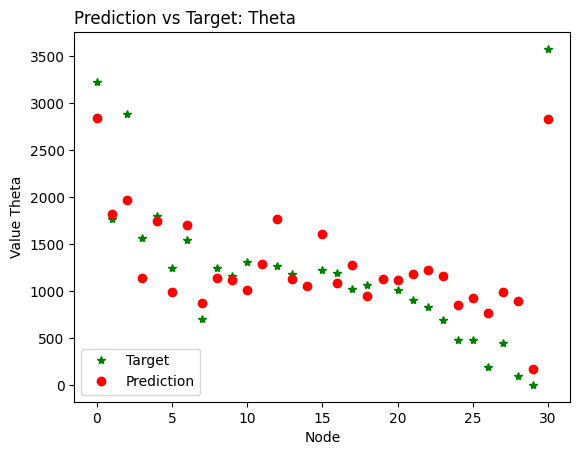

In [41]:
# Graphic for Theta
import matplotlib.pyplot as plt
target1part = extractTarget(test_loader.targets, 1, 0)
prediction1part = extractPredicion(predictions, 2, 0)

plt.plot(target1part,'g*', label='Target')
plt.plot(prediction1part, 'ro', label="Prediction")

plt.title("Prediction vs Target: Theta", loc = 'left')
plt.xlabel("Node")
plt.ylabel("Value Theta")
plt.legend(loc="best")
plt.show()


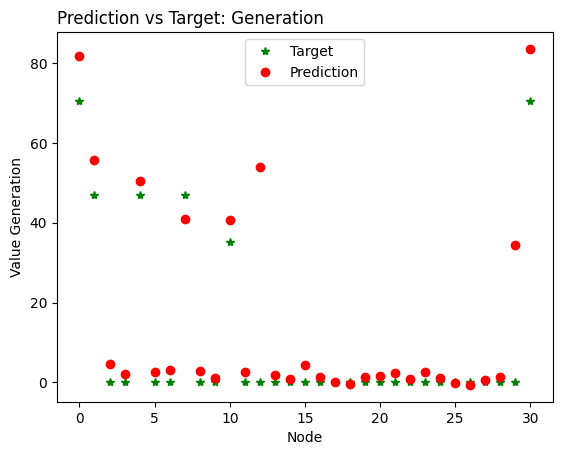

In [40]:
# Graphic for Generation
import matplotlib.pyplot as plt
target1part = extractTarget(test_loader.targets, 1, 0)
prediction1part = extractPredicion(predictions, 1, 0)

plt.plot(target1part,'g*', label='Target')
plt.plot(prediction1part, 'ro', label="Prediction")

plt.title("Prediction vs Target: Generation", loc = 'left')
plt.xlabel("Node")
plt.ylabel("Value Generation")
plt.legend(loc="best")
plt.show()